# Classifying Cyberbullying Tweets

In the age of social media, bullying has become more anonymous as anyone can participate in cyberbullying without repurcussions, making this form of bullying harder to identify and stop.

The dataset is a set of 47,000 "tweets" from the popular social media app Twitter. In this notebook, we try to classify the tweets as related to one of 6 categories:

* Age
* Ethnicity
* Gender
* Religion
* Other
* Not cyberbullying

Kaggle dataset: https://www.kaggle.com/datasets/andrewmvd/cyberbullying-classification

In [34]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import gensim

In [4]:
tweets = pd.read_csv('cyberbullying_tweets.csv')

In [5]:
tweets.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [6]:
tweets.describe()

,tweet_text,cyberbullying_type
count,47692,47692
unique,46017,6
top,RT @sailorhg: the intro for my hardware hackin...,religion
freq,2,7998


In [7]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


In [8]:
tweets.isnull().sum()

,0
tweet_text,0
cyberbullying_type,0


Deleting Duplicate records

In [9]:
tweets.duplicated().sum()

36

In [10]:
tweets.drop_duplicates(inplace=True)
tweets.reset_index(inplace=True)

In [11]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47656 entries, 0 to 47655
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   index               47656 non-null  int64 
 1   tweet_text          47656 non-null  object
 2   cyberbullying_type  47656 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


In [12]:
tweets.cyberbullying_type.value_counts()

,count
cyberbullying_type,
religion,7997
age,7992
ethnicity,7959
gender,7948
not_cyberbullying,7937
other_cyberbullying,7823


The classes are almost equally distributed

In [13]:
tweets.rename(columns={"tweet_text": 'text', 'cyberbullying_type': 'ttype'}, inplace=True)

## EDA

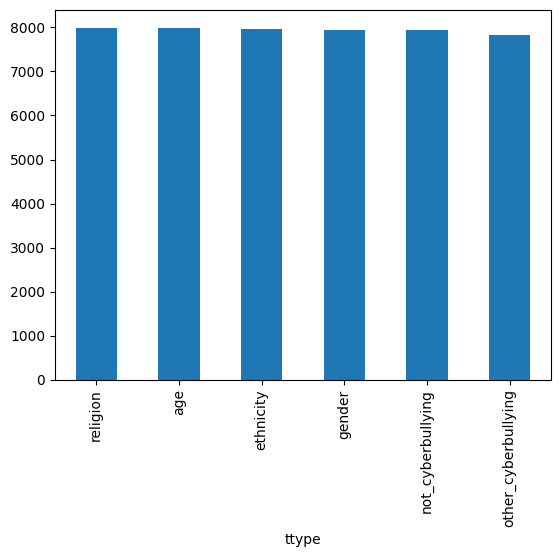

In [14]:
class_counts = tweets.ttype.value_counts()
class_counts.plot(kind='bar')
plt.show()

Wordcloud of most common words

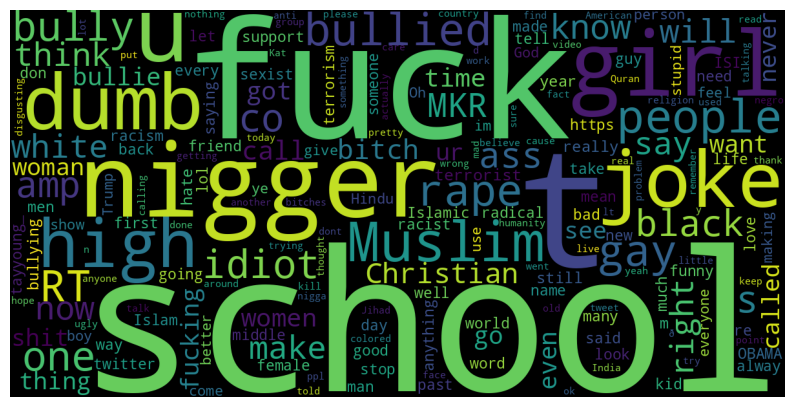

In [15]:
plt.figure(figsize=(10,10))
text = tweets.text.values
cloud = WordCloud(width=1200, height=600, max_words=200, collocations=False).generate(" ".join(text))
plt.axis("off")
plt.imshow(cloud)

What are the most common words in every category?

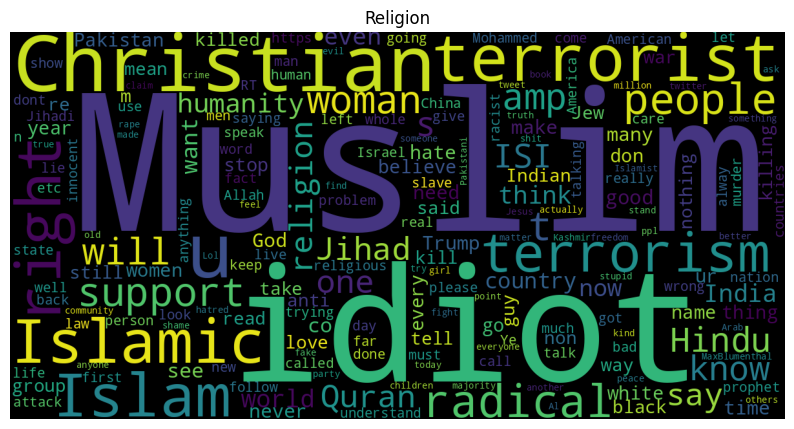

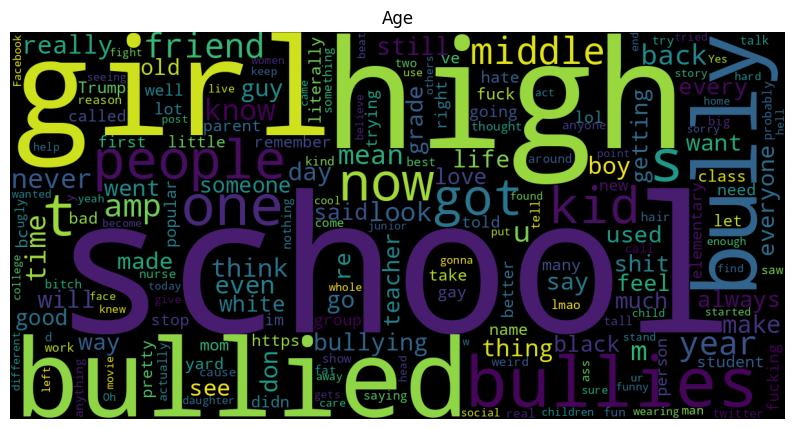

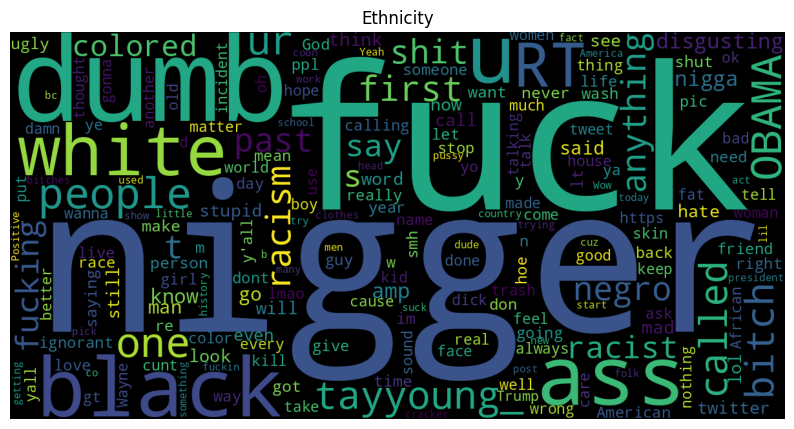

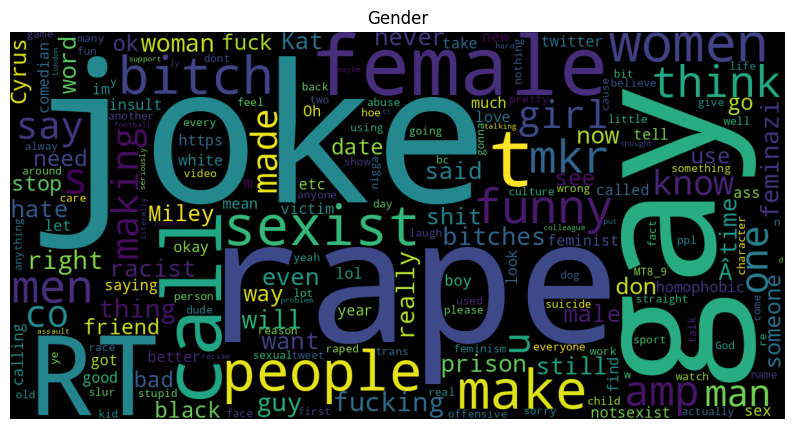

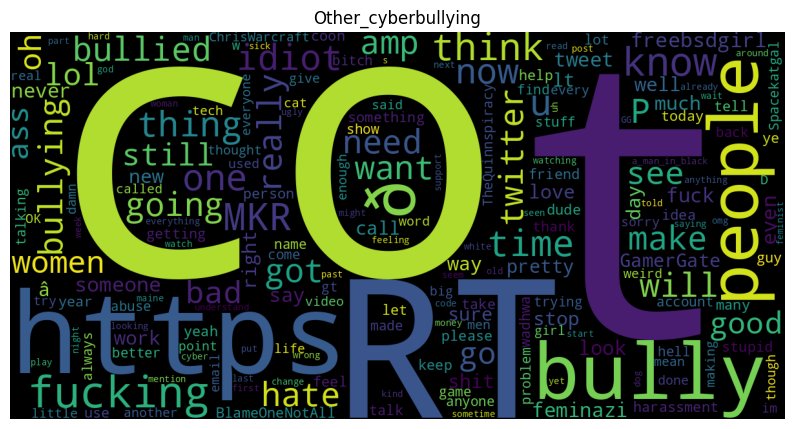

In [16]:
categories = ['religion', 'age', 'ethnicity', 'gender', 'other_cyberbullying']
for category in categories:
  cat_text = tweets[tweets.ttype == category].text.values
  cloud = WordCloud(width=1200, height=600, max_words=200, collocations=False).generate(" ".join(cat_text))
  plt.figure(figsize=(10,10))
  plt.axis("off")
  plt.title(category.capitalize())
  plt.imshow(cloud)

Most common tweet lengths

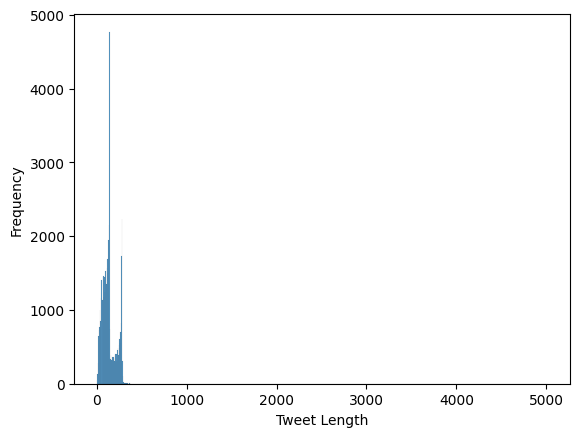

In [17]:
sns.histplot(tweets.text.apply(len))
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.show()

## Data Text Cleaning

In [18]:
tweets.head()

,index,text,ttype
0,0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [19]:
# Clean the text
nltk.download('wordnet')
nltk.download('stopwords')

def remove_special_chars(text):
  text = re.sub(r'http\S+', '', text)
  text = re.sub(r'@\S+', '', text)
  text = re.sub(r'#\S+', '', text)
  text = re.sub(r'[^a-zA-Z\s]', '', text)
  text = text.lower()
  return text

def remove_stopwords(text):
  stop_words = set(stopwords.words('english'))
  words = text.split()
  words = [word for word in words if word not in stop_words]
  return ' '.join(words)

def lemmatize_text(text):
  lemmatizer = nltk.stem.WordNetLemmatizer()
  words = text.split()
  words = [lemmatizer.lemmatize(word) for word in words]
  return ' '.join(words)

def clean_text(text):
  text = remove_special_chars(text)
  text = lemmatize_text(text)
  text = remove_stopwords(text)
  return text

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [20]:
tweets.text = tweets.text.apply(clean_text)

In [21]:
tweets.head()

,index,text,ttype
0,0,word food wa crapilicious,not_cyberbullying
1,1,white,not_cyberbullying
2,2,classy whore red velvet cupcake,not_cyberbullying
3,3,meh p thanks head concerned another angry dude...,not_cyberbullying
4,4,isi account pretending kurdish account like is...,not_cyberbullying


Let's ensure there are no duplicates ad that the classes are balanced

In [22]:
tweets.duplicated().sum()

0

In [23]:
tweets.ttype.value_counts()

,count
ttype,
religion,7997
age,7992
ethnicity,7959
gender,7948
not_cyberbullying,7937
other_cyberbullying,7823


The classes look balanced

## Machine learning

In [24]:
tweets.loc[tweets.ttype == 'not_cyberbullying', 'ttype'] = 0
tweets.loc[tweets.ttype == 'age', 'ttype'] = 1
tweets.loc[tweets.ttype == 'ethnicity', 'ttype'] = 2
tweets.loc[tweets.ttype == 'gender', 'ttype'] = 3
tweets.loc[tweets.ttype == 'religion', 'ttype'] = 4
tweets.loc[tweets.ttype == 'other_cyberbullying', 'ttype'] = 5

In [25]:
tweets.ttype.value_counts()

,count
ttype,
4,7997
1,7992
2,7959
3,7948
0,7937
5,7823


In [26]:
X = tweets.text
y = tweets.ttype

### Train-Test Split

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = y_train.astype('int')
y_test = y_test.astype('int')

### Vectorizing

Let's try 2 methods for vectorizing the tweets.

1. tf-idf
2. Avg Word2Vec




In [28]:
# tf-idf
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [29]:
# Avg Word2Vec
word2vec = gensim.models.Word2Vec(sentences=[sentence.split() for sentence in X_train], vector_size=100, window=5, min_count=1, workers=4)

def avg_word2vec(sentence):
  words = sentence.split()
  vectors = [word2vec.wv[word] for word in words if word in word2vec.wv]
  if len(vectors) == 0:
    return np.zeros(word2vec.vector_size)
  else:
    return np.mean(vectors, axis=0)

X_train_avg_word2vec = np.array([avg_word2vec(sentence) for sentence in X_train])
X_test_avg_word2vec = np.array([avg_word2vec(sentence) for sentence in X_test])

### Training, Predictions and **Accuracy**

In [37]:
# Train models with tfidf data
lr = LogisticRegression(max_iter=1000)
nb = MultinomialNB()
rf = RandomForestClassifier()

lr.fit(X_train_tfidf, y_train)
nb.fit(X_train_tfidf, y_train)

# Predict
lr_tfidf = lr.predict(X_test_tfidf)
nb_tfidf = nb.predict(X_test_tfidf)

print('Logistic Regression: \n')
print('Accuracy:', accuracy_score(y_test, lr_tfidf))
print('Classification Report:\n', classification_report(y_test, lr_tfidf))

print('\nNaive Bayes: \n')
print('Accuracy:', accuracy_score(y_test, nb_tfidf))
print('Classification Report:\n', classification_report(y_test, nb_tfidf))
print('Naive Bayes Accuracy:', accuracy_score(y_test, nb_tfidf))

Logistic Regression: 

Accuracy: 0.8104280318925724
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.54      0.55      1624
           1       0.95      0.97      0.96      1602
           2       0.98      0.98      0.98      1636
           3       0.88      0.82      0.85      1514
           4       0.95      0.94      0.94      1562
           5       0.57      0.63      0.60      1594

    accuracy                           0.81      9532
   macro avg       0.81      0.81      0.81      9532
weighted avg       0.81      0.81      0.81      9532


Naive Bayes: 

Accuracy: 0.7299622324800672
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.31      0.43      1624
           1       0.68      0.98      0.81      1602
           2       0.84      0.91      0.87      1636
           3       0.77      0.83      0.80      1514
           4       0.74      0.96      0.

In [38]:
# Train models with avg_word2vec data
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_avg_word2vec, y_train)

lr_avg_word2vec = lr.predict(X_test_avg_word2vec)

print('Logistic Regression Accuracy:', accuracy_score(y_test, lr_avg_word2vec))
print('Classification Report:\n', classification_report(y_test, lr_avg_word2vec))

Logistic Regression Accuracy: 0.7440201426772975
Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.45      0.46      1624
           1       0.88      0.91      0.90      1602
           2       0.92      0.94      0.93      1636
           3       0.83      0.77      0.80      1514
           4       0.87      0.92      0.90      1562
           5       0.49      0.47      0.48      1594

    accuracy                           0.74      9532
   macro avg       0.74      0.74      0.74      9532
weighted avg       0.74      0.74      0.74      9532



From the prediction results for both tf-idf and avg Word2Vec we can see that the model is worse at predicting tweets of categories not_bullying and other_bullying. We can say this is due to the words used in the bullying categories of a specific type being very close in both the train and test records.

If we wanted higher accuracy in not_bullying and other_bullying for the cost of lesser accuracy in the other categories, Naive Bayes with tf-idf seems to be the best model.

### Confusion Matrix

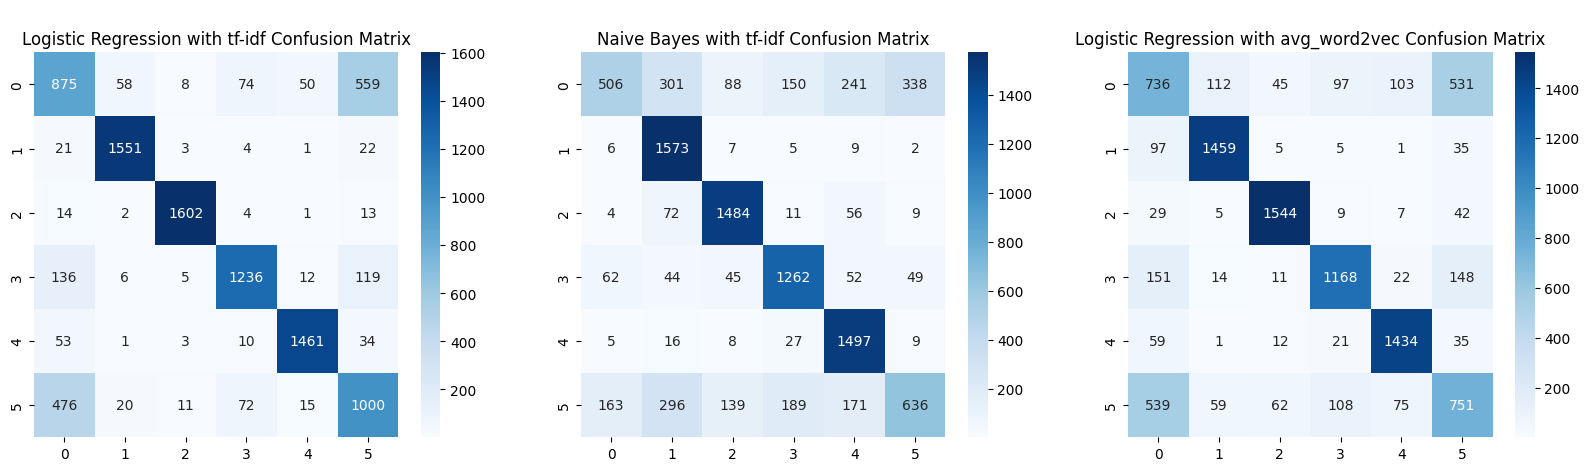

In [53]:
plt.figure(figsize=(20,5))

plt.subplot(1, 3, 1)
plt.title('Logistic Regression with tf-idf Confusion Matrix')
sns.heatmap(confusion_matrix(y_test, lr_tfidf), annot=True, cmap="Blues", fmt='d')

plt.subplot(1, 3, 2)
plt.title('\nNaive Bayes with tf-idf Confusion Matrix')
sns.heatmap(confusion_matrix(y_test, nb_tfidf), annot=True, cmap="Blues", fmt='d')

plt.subplot(1, 3, 3)
plt.title('\nLogistic Regression with avg_word2vec Confusion Matrix')
sns.heatmap(confusion_matrix(y_test, lr_avg_word2vec), annot=True, cmap="Blues", fmt='d')
plt.show()

We can see from the confusion matrix that the model labels a lot of other_bullying cases as not_bullying and vice-versa. If we dropped one of the columns, the model accuracy would increase significantly.